<em>language : Indonesia</em>

<h5> Muhammad Diaz Linggaputra <br> diazlinggaputra@gmail.com</h5>

<h1 style="text-align: center;"> Tugas Akhir Kelas Proyek Analisis Opini Publik </h1>


<h2 style="text-align: center;">Topik: Pengaruh Sentimen Publik terhadap Perubahan <em>Stock Price</em> <br>
     PT Aneka Tambang Tbk. (ANTM)</h2>





<h4>Digunakan tiga metode utama: </h4>

<ul>
    <li><em>Webscrapping</em></li>
    <li><em>Analisis Sentiment</em></li>
    <li><em>Autoregressive with auto_arima modelling</em></li>
</ul>

In [1]:
#import package as needed

#data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#twitter API
import tweepy
import csv

#webscrapping
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import requests
import re
import string

#webscrapping using newspaper library as beautifulsoup supplement
import newspaper
from newspaper import Article

#yahoo finance API
import yfinance as yf
import datetime
from pandas_datareader import data as pdr

#supervised machine learning package with auto_ARIMA model
from pmdarima.arima import auto_arima
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA

#text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#declaring Sastrawi stemming from NLTK (lang=id)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#declaring indonesian stopwords
stop_words = set(stopwords.words('indonesian'))

#top data & wordcloud for word highlighter
import os
from PIL import Image
from wordcloud import WordCloud
import itertools
from nltk.probability import FreqDist

#currdir = os.path.dirname(__file__)

#textblob for sentiment analysis supplement
from textblob import TextBlob
from google_trans_new import google_translator  
import json
import jsonpickle

#declaring assigning google_translator method to translator variable
translator = google_translator()  

#additional library
import warnings
warnings.filterwarnings('ignore')


In [2]:
#showing data of ANTM fluctuation over the past 7 days

#overriding yf for faster result
yf.pdr_override()

#getting the data
data_7d = pdr.get_data_yahoo("ANTM.JK", start="2021-01-28", end="2021-02-06")

df_7d = pd.DataFrame(data_7d)

df_7d.to_csv('ANTM_7day.csv')

#dataframe result
df_7d

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-28,2470.0,2570.0,2380.0,2380.0,2380.0,731854900
2021-01-29,2370.0,2440.0,2220.0,2220.0,2220.0,450321200
2021-02-01,2090.0,2640.0,2070.0,2600.0,2600.0,2186652700
2021-02-02,2600.0,2630.0,2420.0,2420.0,2420.0,942434300
2021-02-03,2390.0,2520.0,2290.0,2330.0,2330.0,948031000
2021-02-04,2400.0,2520.0,2270.0,2400.0,2400.0,874173400
2021-02-05,2450.0,2690.0,2370.0,2660.0,2660.0,1157647700


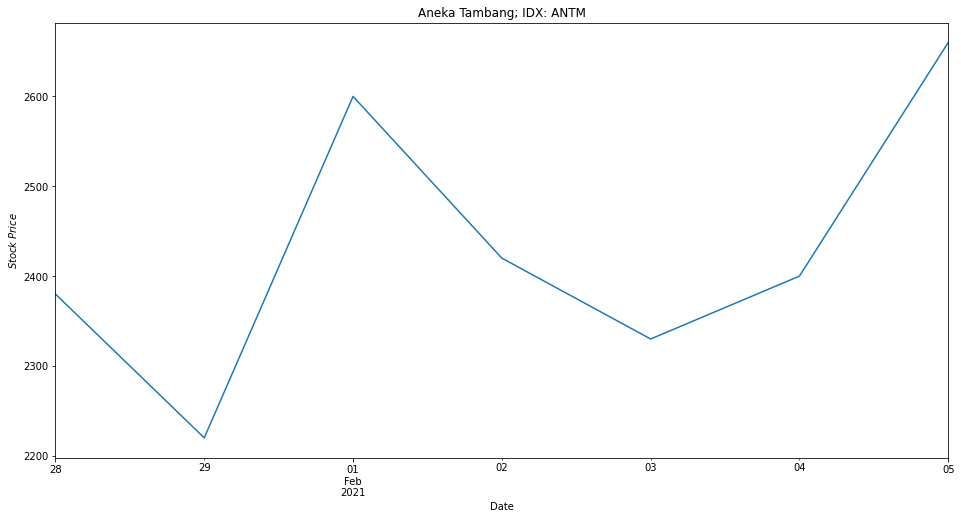

In [3]:
#visualizing ANTM stock price (7 days)

df_7d['Close'].plot(figsize=(16,8))
plt.xlabel("Date")
plt.ylabel("$\it{Stock}$ $\it{Price}$ ")
plt.title('Aneka Tambang; IDX: ANTM', fontsize=12)
plt.show()

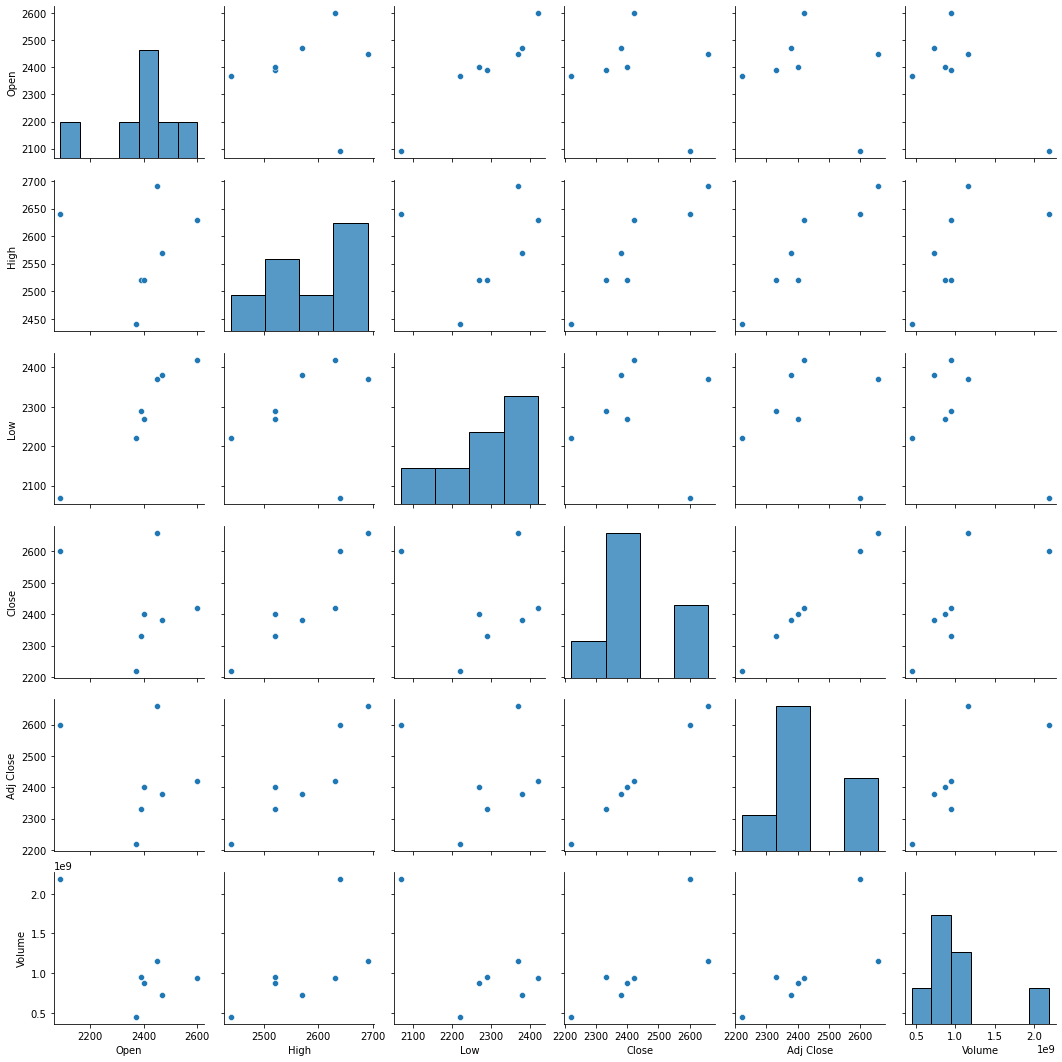

In [4]:
sns.pairplot(df_7d)

[*********************100%***********************]  1 of 1 completed


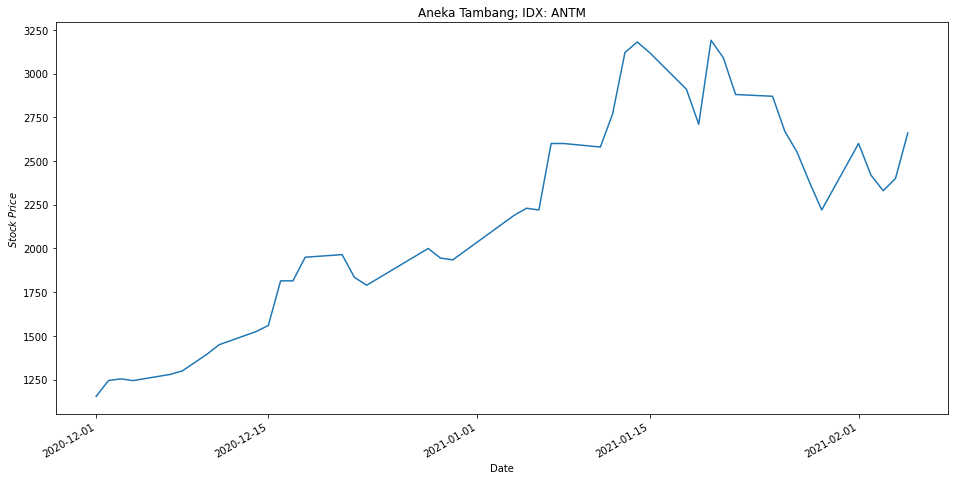

In [5]:
#showing data of ANTM fluctuation over the past last year to date

#overriding yf for faster result
yf.pdr_override()

#getting the data
data_90d = pdr.get_data_yahoo("ANTM.JK", start="2020-12-01", end="2021-02-06")

df_90d = pd.DataFrame(data_90d)
df_90d.to_csv('ANTM_90day.csv')

#visualizing ANTM stock price (7 days)

df_90d['Close'].plot(figsize=(16,8))
plt.xlabel("Date")
plt.ylabel("$\it{Stock}$ $\it{Price}$ ")
plt.title('Aneka Tambang; IDX: ANTM', fontsize=12)
plt.show()

[*********************100%***********************]  1 of 1 completed


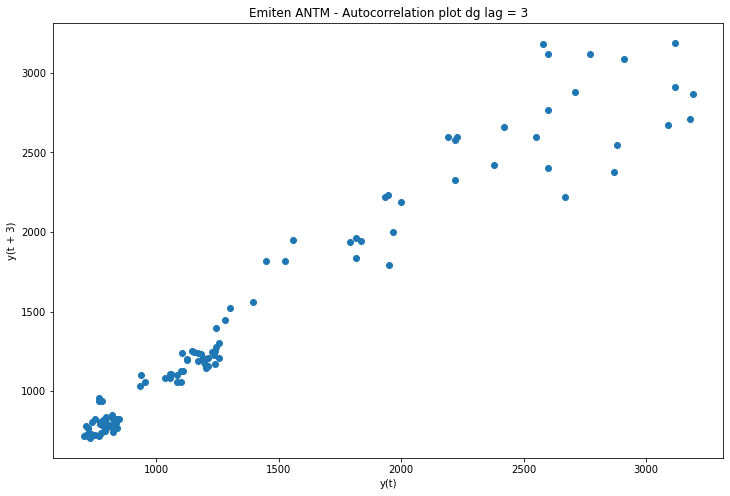

In [6]:
#observing the cross corelation using 6 months period of the model

#getting the data
data_6m = pdr.get_data_yahoo("ANTM.JK", start="2020-08-05", end="2021-02-06")

df_6m = pd.DataFrame(data_6m)

df_6m.to_csv('ANTM_6month.csv')

series = pd.read_csv('ANTM_6month.csv', header=0)

Close = series['Close']

#observing the cross-corelation of the the price data

plt.figure(figsize=(12,8))
lag_plot(Close, lag=3)
plt.title('Emiten ANTM - Autocorrelation plot dg lag = 3')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-293.004, Time=3.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-295.358, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-294.683, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-294.730, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-294.639, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-292.739, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.325 seconds


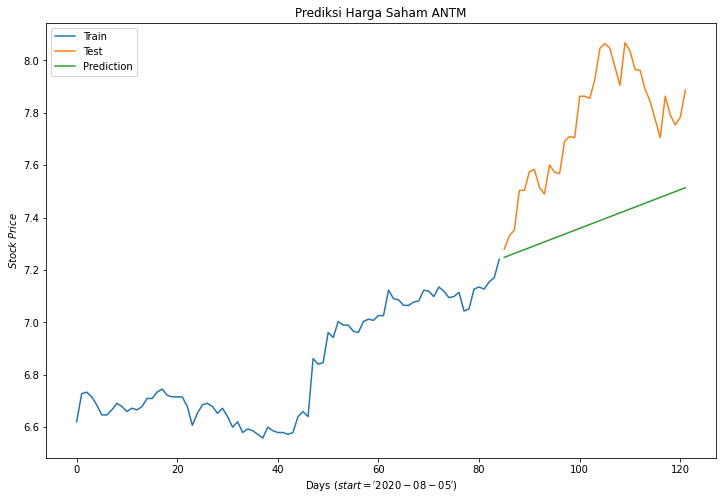

In [7]:
#dividing the data into a training(70%) and test(30%) set for 6m period
train_data, test_data = Close[0:int(len(Close)*0.7)], Close[int(len(Close)*0.7):]

train_data_log = np.log(train_data)
test_data_log = np.log(test_data)

#model build
model = auto_arima(train_data_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_data_log)
forecast = model.predict(n_periods=len(test_data_log))
forecast = pd.DataFrame(forecast, index=test_data_log.index, columns=['Prediction'])

#plot the prediction for validation set
plt.figure(figsize=(12,8))
plt.plot(train_data_log, label="Train")
plt.plot(test_data_log , label="Test")
plt.plot(forecast, label="Prediction")
plt.title("Prediksi Harga Saham ANTM")
plt.xlabel("Days $\it(start='2020-08-05')$")
plt.ylabel("$\it{Stock}$ $\it{Price}$")
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3.756, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7.683, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6.217, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29.768, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.740 seconds


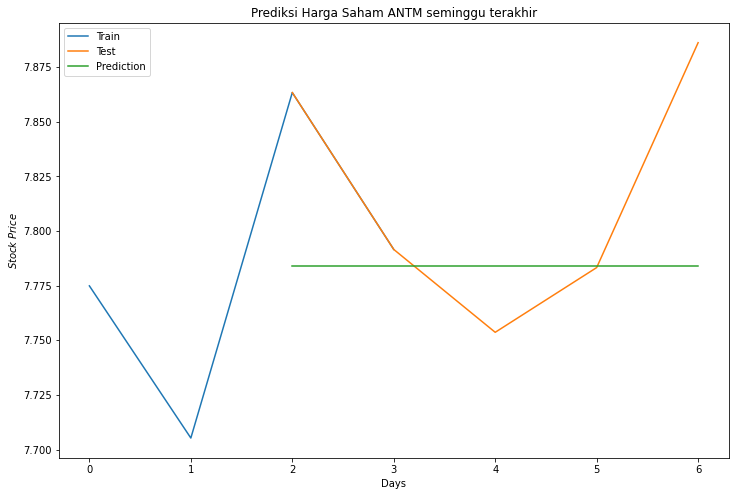

In [8]:
#forecasting stock price using 7 days period of the model

series_7d = pd.read_csv('ANTM_7day.csv', header=0)

Close_7d = series_7d['Close']

#dividing the data into a training(70%) and test(30%) set for 6m period
train_data_7d, test_data_7d = Close_7d[0:int(len(Close_7d)*0.6)], Close_7d[int(len(Close_7d)*0.4):]

train_data_log7d = np.log(train_data_7d)
test_data_log7d = np.log(test_data_7d)

#model build
model = auto_arima(train_data_log7d, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_data_log7d)
forecast7d = model.predict(n_periods=len(test_data_log7d))
forecast7d = pd.DataFrame(forecast7d, index=test_data_log7d.index, columns=['Prediction'])

#plot the prediction for validation set
plt.figure(figsize=(12,8))
plt.plot(train_data_log7d, label="Train")
plt.plot(test_data_log7d , label="Test")
plt.plot(forecast7d, label="Prediction")
plt.title("Prediksi Harga Saham ANTM seminggu terakhir")
plt.xlabel("Days")
plt.ylabel("$\it{Stock}$ $\it{Price}$")
plt.legend()
plt.show()

<h3 style="text-align:center;"> Forecasting Stock Price is Done, proceed to Analyzing Sentiment with Beautifulsoup </h3>

In [9]:
#let's start with getting the url for scraping the data

def getUrl():
    pages = [0, 20] #pages in the site 

    #declaring the link for input to url later
    draft_link = []

    #getting the url that has "antm" in it
    for page in pages:
        url = "https://www.kontan.co.id/search/?search=antm&per_page={}".format(page)
        html = urlopen(url)
        data = BeautifulSoup(html, 'html.parser')
        items = data.findAll('a', {'href': re.compile(r'antm')})
        for link in data.find_all('a', {'href': re.compile(r'antm')}):
            draft_link.append(link.get('href')) 
        
    #removing duplicate list (this happened for no reason..)
    draft_link = list(dict.fromkeys(draft_link))

    #removing url that is not relevant
    clean_link = [i for i in draft_link if 'search' not in i]
        
    return clean_link

In [10]:
news_url = getUrl()
news_text = [] #Kontan News list/array

for news in news_url:
    news_link = "https:{}".format(news)
    article = Article(news_link)
    article.download()
    article.parse()
    news_text.append(article.text)
    
news_text[21] #output looks good

'ILUSTRASI. Pertambangan bauksit milik PT Aneka Tambang Tbk (ANTM)\n\nReporter: Akhmad Suryahadi | Editor: Anna Suci Perwitasari\n\nKONTAN.CO.ID - JAKARTA. PT Aneka Tambang Tbk (ANTM) mendapatkan persetujuan ekspor mineral logam untuk penjualan ekspor bijih bauksit tercuci dengan kadar Al2o3 = 42% sebesar 1,89 juta wet metrik ton (wmt) untuk periode 2021-2022.\n\nPerusahaan tambang milik negara tersebut memperoleh izin ekspor atas pelaksanaan proyek hilirisasi pabrik Smelter Grad Alumina Refinery (SGAR). Adapun izin ekspor mineral ini melengkapi izin ekspor bijih bauksit yang telah dimiliki ANTM sebelumnya, yakni sebesar 840.000 wmt atas kepemilikan pabrik Chemical Grade Alumina (CGA) di Tayan.\n\nBerdasarkan Peraturan Menteri Energi dan Sumber Daya Mineral No. 17 tahun 2020 tentang Pengusahaan Pertambangan Mineral dan Batubara, ANTM masuk dalam kriteria Perusahaan pemegang Izin Usaha Pertambangan (IUP) Operasi Produksi Bauksit yang telah memiliki dan mengoperasikan serta mengembangkan

In [11]:
#accessing positive and negative words in local library
positiveList= open("./kata_positif.txt","r")
positiveWords = positiveList.readlines()

negativeList= open("./kata_negatif.txt","r")
negativeWords = negativeList.readlines()

differencePosNeg = [] #used for finding mean and std

for item in news_text: #looping on news_text list
    count_p = 0 #initating positive word as 0
    count_n = 0 #initating negative word as 0
    for word_positive in positiveWords:
        if word_positive.strip() in item:
            count_p +=1
    for word_negative in negativeWords:
        if word_negative.strip() in item:
            count_n +=1
            
    print ("Positive word: "+str(count_p)) #positive word based on library
    print ("Negative word: "+str(count_n)) #negative word based on library
    
    differencePosNeg.append(count_p - count_n)
    print ("-----------------------------------------------------")

Positive word: 21
Negative word: 15
-----------------------------------------------------
Positive word: 22
Negative word: 12
-----------------------------------------------------
Positive word: 33
Negative word: 11
-----------------------------------------------------
Positive word: 18
Negative word: 7
-----------------------------------------------------
Positive word: 0
Negative word: 2
-----------------------------------------------------
Positive word: 15
Negative word: 11
-----------------------------------------------------
Positive word: 25
Negative word: 9
-----------------------------------------------------
Positive word: 42
Negative word: 11
-----------------------------------------------------
Positive word: 18
Negative word: 11
-----------------------------------------------------
Positive word: 17
Negative word: 4
-----------------------------------------------------
Positive word: 27
Negative word: 12
-----------------------------------------------------
Positive word: 

In [12]:
#showing the distributions of the compiled news

print ("Word Tendencies Avg: "+str(np.mean(differencePosNeg)))
print ("Standard Deviation (std): "+str(np.std(differencePosNeg)))

Word Tendencies Avg: 11.025
Standard Deviation (std): 7.7475399321332965


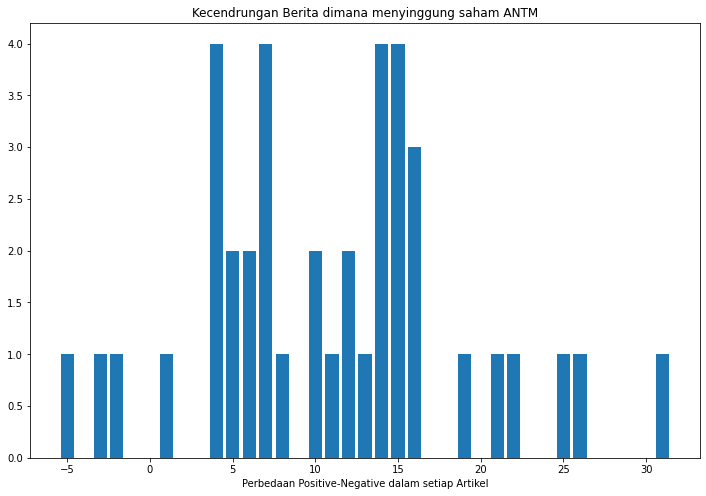

In [13]:
#visualizing difference word and polarities of the sentiment

labels, counts = np.unique(differencePosNeg, return_counts=True)

plt.figure(figsize=(12,8))
plt.title("Kecendrungan Berita dimana menyinggung saham ANTM", fontsize=12) #news tendency of the current topic
plt.xlabel("Perbedaan Positive-Negative dalam setiap Artikel") #each articles differences
plt.bar(labels, counts, align='center')
plt.show()

In [14]:
#proceed to text-preprocessing

#declaring text preprocessing function for inputted arguments
#this would later be used for webscrapping and twitter surfing

def textCleaner(text_list):
    #text folding
    
    #transforming text to lowercase
    cleaned_news_list = [item.lower() for item in news_text]
    
    #deleting numeric text
    cleaned_news_list = [re.sub(r"\d+", "", item) for item in cleaned_news_list]
    
    #deleting http text
    cleaned_news_list = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item).split()) for item in cleaned_news_list]
    
    #deleting punctuation [!”#$%&’_`~]
    cleaned_news_list = [item.translate(str.maketrans("","",string.punctuation)) for item in cleaned_news_list] 
    
    #deleting whitespaces contained
    cleaned_news_list = [item.strip() for item in cleaned_news_list]
    return cleaned_news_list

def textStemming(text_list):
    list_to_stem = textCleaner(text_list)

    #joining the list
    wholeParagraf = ' '.join(list_to_stem)

    #tokenizing words and/or stopping certain words using stop_words
    word_tokens = word_tokenize(wholeParagraf)
    wholeParagraf_2 = ' '.join([w for w in word_tokens if not w in stop_words]) 

    #words stemming w/ Sastrawi
    wordsStemmed   = stemmer.stem(wholeParagraf_2)
    return wordsStemmed

#sample result as follows
textStemming(news_text)

'reporter akhmad suryahadi editor yudho winarto kontan co id jakarta nikel salah komoditas yakin sinar kutip bloomberg harga nikel bursa london metal exchange lme kontrak bulan level us rabu analis nilai naik harga nikel batas iring naik harga masif januari analis nh korindo sekuritas indonesia maryoki pajri alhusnah berekspektasi harga nikel kisar us us ton kondisi ekspektasi proyeksi naik harga nikel signifikan baca rencana investasi tesla dampak positif saham antm katalis katalis nikel proyeksi harga nikel volatile rentang us us ton terang maryoki salah katalis china negeri tirai bambu rencana tingkat konsumsi nikel kendara listrik stainless steel batas ekspor bijih nikel laku perintah indonesia katalis positif nikel harga nikel poles ekspektasi minta kendara listrik program stimulus negara dukung kendara listrik imbang dampak ekonomi pandemi donasi voucer gratis ungkap terimakasih perhati sedia voucer gratis nila donasi belanja dukung tambah semangat saji artikel artikel kualitas m

<h3 style="text-align:center;"> Analyzing News Sentiment is Done, proceed to Analyzing Sentiment on Twitter </h3>

In [15]:
#proceed to twitter sentiment analysis
#twitter dev auth
#using tweepy package

consumer_key = "t8f0rO81GoEHdak4oTbZN7UAh" #API Key
consumer_secret = "NCPZGkyKIUKw3Jgf9zG6XeU7Iertb15OvwKUftgXhZ5vi0Smz8" #API Key Secret
access_token = "83316046-ANlQ4zJdLvBoGszoD14dHYMh1aCBJ0qG6q5BgB2BM" #Check Keys and Token
access_token_secret = "bYu5X3uLfK7g0oOnuC2lTv17dvAzlffQCq1TejIIfIlHC"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

#authorization completed

In [16]:
search_words = "antm"
date_since = "2020-01-29"
date_until = "2021-02-06" 
new_search = search_words + " -filter:retweets" #disabled retweets, only the original one
tweetsPerQry = 100 #numbers per batch
fname = "tweets.txt"
sinceId = None

In [17]:
max_id= -1
maxTweets = 5000 #max numbers of tweets retrieved

tweetCount = 0 #initiating tweet counter
print("Downloading max {0} tweets".format(maxTweets))

with open(fname,'w') as f:
    while tweetCount < maxTweets:
        tweets = []
        try: #error handling initiated
            if(max_id <= 0):
                if(not sinceId):
                    new_tweets = api.search(q=search_words, lang="id", count=tweetsPerQry, tweet_mode="extended",
                                           since=date_since, until=date_until)
                else:
                    new_tweets = api.search(q=search_words, lang="id", count=tweetsPerQry, tweet_mode="extended", 
                                           since=date_since, until=date_until, since_id= sinceId)
            else:
                if(not sinceId):
                    new_tweets = api.search(q=search_words, lang="id", count=tweetsPerQry, tweet_mode="extended",
                                            max_id=str(max_id -1), since=date_since, until=date_until)
                else:
                    new_tweets = api.search(q=search_words, lang="id", count=tweetsPerQry, tweet_mode="extended",
                                            max_id=str(max_i,d -1), since_id= sinceId,
                                            since=date_since, until=date_until)
            
            if not new_tweets:
                print("No more tweets found; THATS ALL FOLKS!")
                break
            for tweet in new_tweets:
                #removing whitespaces
                f.write(str(tweet.full_text.replace('\n','').encode("utf-8"))+"\n")
                
            tweetCount+= len(new_tweets)
            print("Downloading max {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
            
        except tweepy.TweepError as e: #escaping error
            print("this is the error: " + str(e))
            break

print("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fname))
                    

No more tweets found; THATS ALL FOLKS!
Downloaded 1581 tweets, Saved to tweets.txt


In [18]:
#tweet text cleaning function
def cleaningTweet(tweet):
    tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet) #split()
    return tweet

#accessing cleaned tweet text as a function
def accessingTxt(file_name):
    with open(file_name, 'r') as f:
        tweets = [cleaningTweet(line.strip()) for line in f]
    f.close
    return tweets

In [ ]:
#asking permission to google translator
#-------------------------------- I SKIPPED THIS -----------------------------------

requests.get("https://translate.google.cn/", headers = {'User-agent': 'myApp'}) #permission to strike, commander

#PERMISSION DENIED GOD DAMN IT MAN

tweets = accessingTxt(fname)
tweetsTrans = []

#translating tweet from id to en
for i in range(len(tweets)):
    tweetTranslated = translator.translate(tweets[i])
    tweetsTrans.append(tweetTranslated)

<h4><em>Important NOTE: Since I was always encountered error in translating indonesian tweet to English due to API decline, I hardcoded it directly on the site instead. My apologize! </em> </h4>

In [20]:
#declaring polarity and subjectivity

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [21]:
#declaring polarity and subjectivity of tweet text

tweet_harcoded = accessingTxt('tweets_hardcoded.txt') #hardcoded translation

tweet_polarity = np.zeros(len(tweet_harcoded))
tweet_subjectivity = np.zeros(len(tweet_harcoded))

for index, tweet in enumerate(tweet_harcoded):
    tweet_polarity[index] = polarity(tweet)
    tweet_subjectivity[index] = subjectivity(tweet)

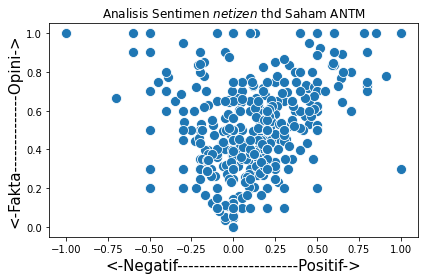

In [22]:
#visualizing the relation between polarity and subjectivity

sns.scatterplot(tweet_polarity, #x-axis
                tweet_subjectivity, #y-axis
                s=100)

plt.title("Analisis Sentimen $\it{netizen}$ thd Saham ANTM", fontsize=12)
plt.xlabel("<-Negatif----------------------Positif->", fontsize=15)
plt.ylabel("<-Fakta--------------Opini->", fontsize=15)
plt.tight_layout()

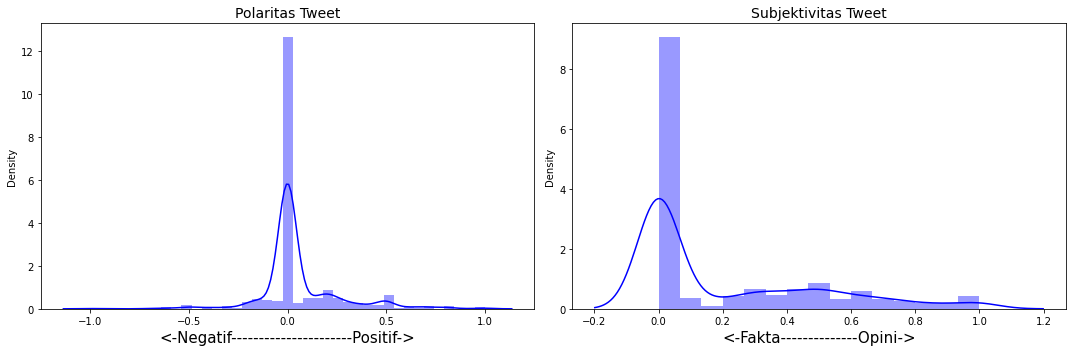

In [23]:
#histogram of each polarity and subjectivity in descriptive statistics plots

f, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(tweet_polarity, color="b", ax=axs[0])
axs[0].set_title("Polaritas Tweet", fontsize=14)
axs[0].set_xlabel("<-Negatif----------------------Positif->", fontsize=15)

sns.distplot(tweet_subjectivity, color="b", ax=axs[1])
axs[1].set_title("Subjektivitas Tweet", fontsize=14)
axs[1].set_xlabel("<-Fakta--------------Opini->", fontsize=15)

plt.tight_layout()

<h3 style="text-align:center;">Analyzing Sentiment on Twitter is Done, Proceed to Showing WordCloud on an Influencer Based News</h3>

In [24]:
#showing data of ANTM fluctuation after influencer by the username: @kaesangp tweeted

#getting the data
data_custom = pdr.get_data_yahoo("ANTM.JK", start="2021-01-04", end="2021-01-09")

df_custom = pd.DataFrame(data_custom)

df_custom.to_csv('ANTM_kaesangp.csv')

#dataframe result
df_custom

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,1970.0,2200.0,1940.0,2190.0,2190.0,1040753400
2021-01-05,2190.0,2340.0,2130.0,2230.0,2230.0,1139014700
2021-01-06,2270.0,2290.0,2130.0,2220.0,2220.0,629211500
2021-01-07,2250.0,2740.0,2240.0,2600.0,2600.0,1982112200
2021-01-08,2640.0,2750.0,2560.0,2600.0,2600.0,1052618000


In [25]:
#this dataframe below is showing on how a tweet might impact the market

df_custom["Change %"] = df_custom.Close.pct_change() * 100

df_custom

,Open,High,Low,Close,Adj Close,Volume,Change %
Date,,,,,,,
2021-01-04,1970.0,2200.0,1940.0,2190.0,2190.0,1040753400,NaN
2021-01-05,2190.0,2340.0,2130.0,2230.0,2230.0,1139014700,1.826484
2021-01-06,2270.0,2290.0,2130.0,2220.0,2220.0,629211500,-0.448430
2021-01-07,2250.0,2740.0,2240.0,2600.0,2600.0,1982112200,17.117117
2021-01-08,2640.0,2750.0,2560.0,2600.0,2600.0,1052618000,0.000000


In [26]:
#declaring word cloud and top data as a function

def textTopData(text_list):
    #declaring data
    data = textStemming(text_list)
    
    #text wordcloud 
    wordcloud = WordCloud(background_color="white", width=1600, height=1000, max_words=200, max_font_size=250).generate(data)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    #text show counter
    #converting string into list clean data
    dataCount = data.split(" ")

    #most frequent text 
    fqdist = FreqDist(dataCount)

    #data visualizing
    plt.figure(figsize=(12,8))
    plt.title("Most Top Data", fontsize=15)
    fqdist.plot(20,cumulative=False)
    plt.show()

In [27]:
#1 (first) news

news_url = [
        '//finance.detik.com/bursa-dan-valas/d-5326196/pergerakan-saham-antm-setelah-dicolek-kaesang'
]

news_text = [] #Custom News list/array

for news in news_url:
    news_link = "https:{}".format(news)
    article = Article(news_link)
    article.download()
    article.parse()
    news_text.append(article.text)

#example result is as follows
news_text

['Putra Presiden Joko Widodo (Jokowi) Kaesang Pangarep beberapa hari ini kerap mencuit saham PT Aneka Tambang (ANTM) Tbk. Kemarin ia kembali menyinggung saham emiten pertambangan logam tersebut di akun Twitter pribadinya. Ia memberi sinyal, saham emiten pelat merah itu bisa tembus ke level 4.000/lembar saham.\n\nUsai dicolek Kaesang, emiten berkode saham ANTM terus melanjutkan tren positifnya.\n\nMelansir data RTI hari ini, Jumat (8/1/2020), hingga pukul 9.50 waktu JATS saham antam naik 4,62% atau 120 poin ke posisi Rp 2.720 per lembar.\n\nJika dilihat dari awal tahun atau selama sepekan saja saham ANTM sudah naik 24,2%. Pada perdagangan pertama tahun ini di 4 Januari 2020 saham ANTM masih bertengger di level Rp 2.190 per lembar.\n\nSaham ANTM saat ini memiliki rasio price book value (PBV) 3,43 kali. Sedangkan earning per share atau laba bersih per saham Rp 46.\n\nIndeks Harga Saham Gabungan (IHSG) pagi ini dibuka hijau. IHSG kembali menguat dan dibuka naik 42 poin (0,69%) ke level 6.1

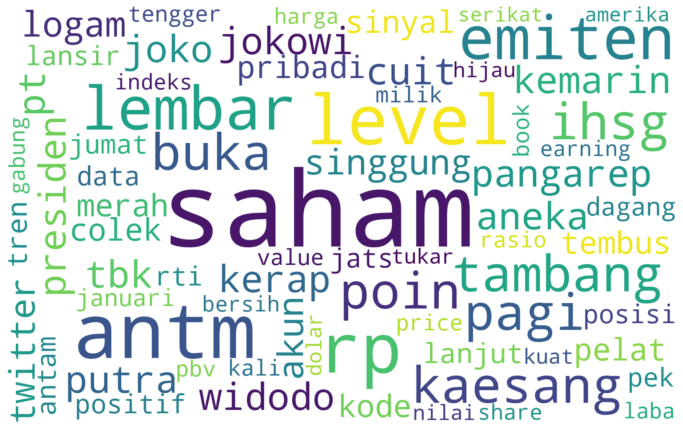

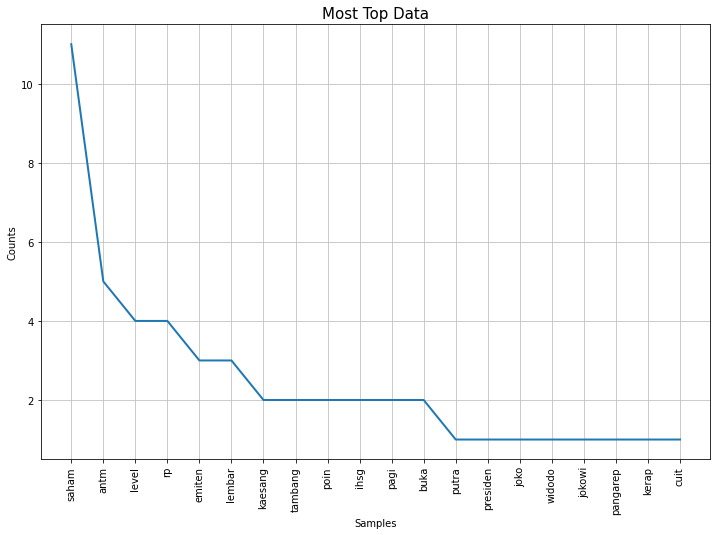

In [28]:
textTopData(news_text)

In [29]:
#2 (second) news

news_url = [
        '//www.cnbcindonesia.com/market/20210104131226-17-213308/diborong-kaesang-lagi-saham-antam-melesat-75'
]

news_text = [] #Custom News list/array

for news in news_url:
    news_link = "https:{}".format(news)
    article = Article(news_link)
    article.download()
    article.parse()
    news_text.append(article.text)

#example result is as follows
news_text

['Jakarta, CNBC Indonesia - Putra Bungsu Presiden Joko Widodo, Kaesang Pangarep, kembali mengumumkan menambah portofolio investasi pada saham PT Aneka Tambang Tbk (ANTM).\n\nDalam akun twitter pribadinya Kaesang menyampaikan hal tersebut. Ia menyampaikan hal tersebut setelah, salah satu akun netizen @morningkixxx menanyakan apakah masih menahan saham ANTM setelah sempat dibeli beberapa waktu lalu.\n\n"Pagi tadi nambah muatan saya di $ANTM," balas Kaesang melalui akun twitternya, yang di posting hari ini, Senin (4/1/2021).\n\nPada Selasa (15/12/2020), Kaesang sempat menyebutkan saham ANTM dalam postingan di akun Twitternya.\n\nHari ini harga saham ANTM menguat 7,49% ke level 2.080/unit. Nilai transaksi saham ini mencapai Rp, 1,23 triliun dengan volume 613,78 juta saham.\n\nKaesang adalah seorang pengusaha, pemilik PT Harapan Bangsa Kita atau Hebat, yang merupakan induk usaha dari bisnis food and beverage yang dijalankan Kaesang. Brand makanan tersebut antara lain, Sang Pisang, Yang Ayam

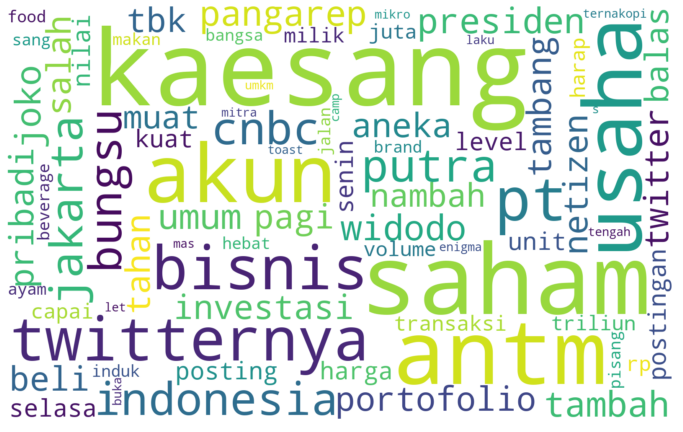

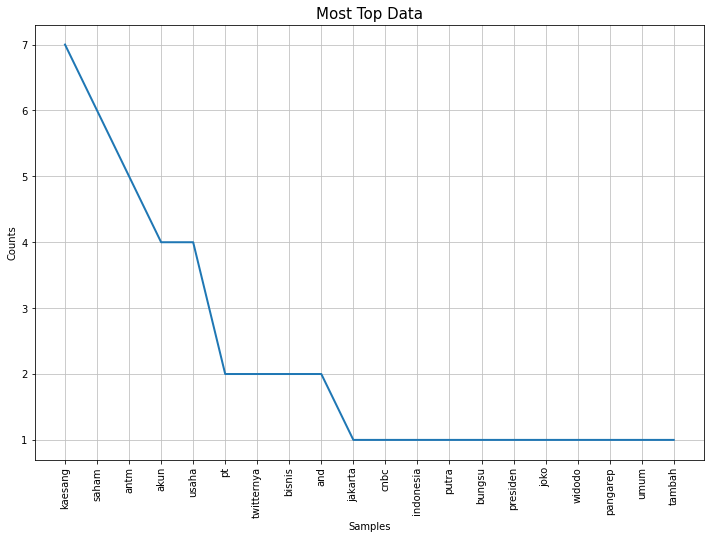

In [30]:
#used data for presentation
textTopData(news_text)